In [ ]:
# 난 사용하지 않았음.
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

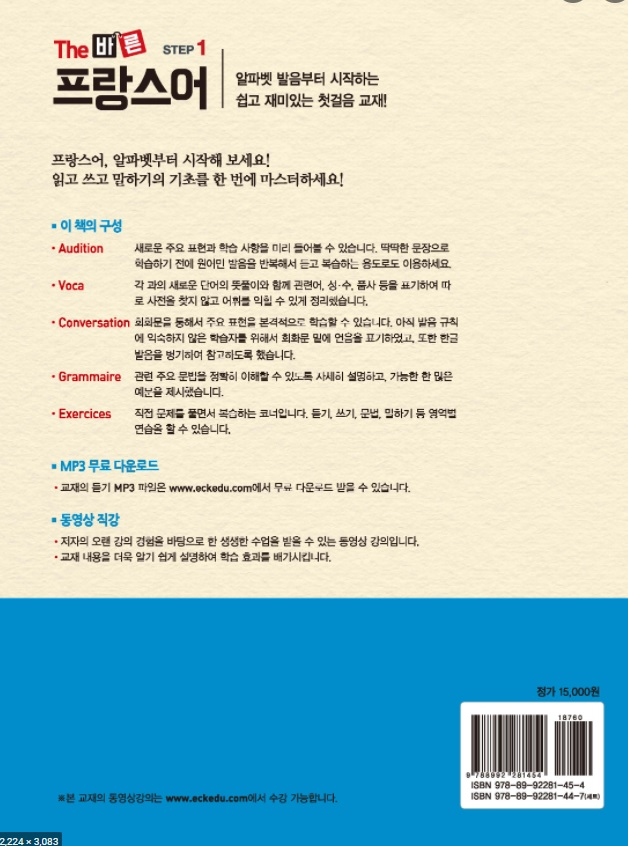

In [3]:
#이미지 불러오는 함수
def get_image():
    file='/content/test/0404_test.jpg'
    img=cv2.imread(file, cv2.IMREAD_COLOR)
    file= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv2_imshow(img)
  
if __name__=='__main__':
    get_image()

In [4]:
#Kako OCR api
import json

import requests
import sys

LIMIT_PX = 1024
LIMIT_BYTE = 1024*1024  # 1MB
LIMIT_BOX = 40


def kakao_ocr_resize(image_path: str):
    """
    ocr detect/recognize api helper
    ocr api의 제약사항이 넘어서는 이미지는 요청 이전에 전처리가 필요.

    pixel 제약사항 초과: resize
    용량 제약사항 초과  : 다른 포맷으로 압축, 이미지 분할 등의 처리 필요. (예제에서 제공하지 않음)

    :param image_path: 이미지파일 경로
    :return:
    """
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    if LIMIT_PX < height or LIMIT_PX < width:
        ratio = float(LIMIT_PX) / max(height, width)
        image = cv2.resize(image, None, fx=ratio, fy=ratio)
        height, width, _ = height, width, _ = image.shape

        # api 사용전에 이미지가 resize된 경우, recognize시 resize된 결과를 사용해야함.
        image_path = "{}_resized.jpg".format(image_path)
        cv2.imwrite(image_path, image)

        return image_path
    return None


def kakao_ocr(image_path: str, appkey: str):
    """
    OCR api request example
    :param image_path: 이미지파일 경로
    :param appkey: 카카오 앱 REST API 키
    """
    API_URL = 'https://dapi.kakao.com/v2/vision/text/ocr'

    headers = {'Authorization': 'KakaoAK {}'.format(appkey)}

    image = cv2.imread(image_path)
    jpeg_image = cv2.imencode(".jpg", image)[1]
    data = jpeg_image.tobytes()


    return requests.post(API_URL, headers=headers, files={"image": data})

In [30]:
import requests, json
from PIL import Image, ImageDraw
import json

import requests
import sys

MYAPP_KEY = 'f7bd096a7cbd9813920dcc2c5e292f40'
 
def detect_area(filename):
    API_URL = 'https://dapi.kakao.com/v2/vision/text/ocr'
    headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}
    try:
        image = cv2.imread(filename)
        jpeg_image = cv2.imencode(".jpg", image)[1]
        data = jpeg_image.tobytes()
        
        resp = requests.post(API_URL, headers=headers, files={"image":data})
        resp.raise_for_status()
        res = list()
        for i in range(len(resp.json()['result'])) :
          res.append(resp.json()['result'][i]['boxes'])
        return res
    except Exception as e:
        print(str(e))
 
def processing(file, box_list):
    im = Image.open(file)
    draw = ImageDraw.Draw(im)
    for box in box_list:
        for a in range(0, 4):
            if a <= 2:
                b = a + 1
            else:
                b = 0
            draw.line(box[a] + box[b], fill=128, width=5)
    return im
 
file = '/content/test/0404_test.jpg'
box_list = detect_area(file)
print(box_list)
im = processing(file, box_list)
filename = ''.join(file.split('.')[:-1]) + '_detect.' + file.split('.')[-1]
im.save(filename)

[[[50, 35], [143, 30], [144, 55], [52, 61]], [[196, 39], [205, 38], [206, 55], [197, 56]], [[162, 43], [194, 41], [194, 54], [163, 55]], [[53, 65], [207, 64], [207, 111], [53, 113]], [[235, 68], [381, 69], [380, 88], [235, 87]], [[238, 92], [384, 93], [384, 108], [237, 106]], [[53, 151], [266, 151], [266, 168], [53, 168]], [[44, 171], [348, 169], [349, 186], [45, 188]], [[73, 215], [97, 216], [97, 234], [73, 233]], [[49, 219], [69, 219], [69, 232], [49, 232]], [[99, 218], [123, 218], [123, 234], [99, 234]], [[57, 242], [104, 242], [104, 255], [57, 255]], [[136, 243], [448, 235], [448, 254], [136, 261]], [[135, 256], [449, 245], [450, 267], [135, 277]], [[51, 277], [85, 279], [84, 292], [51, 291]], [[169, 279], [200, 279], [200, 291], [169, 291]], [[199, 279], [230, 278], [230, 290], [200, 292]], [[269, 279], [292, 277], [293, 290], [271, 293]], [[294, 278], [323, 278], [323, 292], [294, 292]], [[328, 279], [353, 279], [353, 292], [328, 292]], [[357, 279], [376, 279], [376, 291], [357, 

In [51]:
import re

def main():
    if len(sys.argv) != 3:
        print("Please run with args: $ python example.py /path/to/image appkey")
    image_path, appkey = '/content/test/0404_test.jpg', 'f7bd096a7cbd9813920dcc2c5e292f40'

    resize_impath = kakao_ocr_resize(image_path)
    if resize_impath is not None:
        image_path = resize_impath
        print("원본 대신 리사이즈된 이미지를 사용합니다.")

    #카카오 API에서 범위, 인식한 글씨 받기
    output = kakao_ocr(image_path, appkey).json()
    outputdata = json.dumps(output, ensure_ascii=False,sort_keys=True, indent=2)
    #print("[OCR] output:\n{}\n".format(outputdata))

    #받은 데이터 array로 변환
    outputdata = json.loads(outputdata)
    #print(str(outputdata))

    if 'result' in outputdata :
      for i in range(len(outputdata['result'])):
        word = outputdata['result'][i]['recognition_words'][0]
        word = word.strip()
    
        x = outputdata['result'][i]['boxes'][0][0]
        y = outputdata['result'][i]['boxes'][0][1]
        w = outputdata['result'][i]['boxes'][1][0] - outputdata['result'][i]['boxes'][0][0]
        h = outputdata['result'][i]['boxes'][2][1] - outputdata['result'][i]['boxes'][0][1]

        # 원본 이미지
        org_img = cv2.imread(image_path)

        if word.find('ISBN') != -1:
          if re.search('\d', word) == None:
            
            nextX = outputdata['result'][i + 1]['boxes'][0][0]
            nextY = outputdata['result'][i + 1]['boxes'][0][1]
            nextW = outputdata['result'][i + 1]['boxes'][1][0] - outputdata['result'][i + 1]['boxes'][0][0]
            nextH = outputdata['result'][i + 1]['boxes'][2][1] - outputdata['result'][i + 1]['boxes'][0][1]

            # 자른 이미지
            cut_img = org_img[y:y+h, x:x+w]
            cut_img2 = org_img[y:nextY+nextH]

            # 자른 이미지 출력
            cv2_imshow(cut_img)
            cv2_imshow(cut_img2)
            word = outputdata['result'][i]['recognition_words'][0]
            if re.search('\d', outputdata['result'][i + 1]['recognition_words'][0]) == None:
              continue
            # 추출된 isbn에서 알파벳이 포함 되어 있으면 제거
            re_word = re.sub(r"[a-z]", "", outputdata['result'][i + 1]['recognition_words'][0])
            word += " : " + re_word
          else :
            # 자른 이미지
            cut_img = org_img[y:y+h, x:x+w]
            # 자른 이미지 출력
            cv2_imshow(cut_img)

          # 양 끝에 하이폰 있으면 제거
          word = word.strip('-')
          print(word)

    else:
       print('사진 인식 실패')

if __name__ == "__main__":
    main()

ISBN : 978-89


ISBN : 978-89-92281-44-70
